# Sample notebook in R for accessing the Agrimetrics GraphQL API to obtain geospatial data from multiple measures within a bounded region

Agrimetrics' GraphQL API provides a convenient interface through which data hosted in the Agrimetrics Data Platform can be queried. Since some of these datasets are geospatially indexed (geospatialMeasures), querying the API with a region of interest, whether a polygon or point, will yield data that are implicitly geospatially related. Since all geospatialMeasures data are queried in the same manner - for a given region, return all selected data for the specified datasets - to reduce some of the boiler-plate code that would otherwise be needed, some helper functions have been written and included in this repository. This notebook aims to demonstrate how to query for and visualise data using these helper functions.

In this notebook, you will find a few GraphQL queries that have been copied directly from the Query Builder [webapp](https://app.agrimetrics.co.uk/graph-explorer). The queries used here have been crafted within the webapp and  pasted into the notebook to demonstrate how you might generate quick visualisations of data of interest. Should there be an alternate set of data of interest, replace the queries below as needed.

## Requirements

You will need a subscription key to run this example. Your subscription key is available through the Agrimetrics developer portal:

* Log in at https://developer.agrimetrics.co.uk/.
* Open your profile through the menu on the top right of the page with your name on it.
* Copy one of your subscription keys from the "Field Explorer Subscription" section.
* Depending on your subscription (trial vs. paid) amount of data available in this demo may vary. 

## Setup

In the following cell `utils`, `transformData`, and `graphqlClient` helper functions have been imported. These files are included in the [Github repository](https://github.com/agrimetrics/api-examples) along with this notebook. If you want to tweak the notebook in any way and host it locally, be sure to copy the notebook along with these helper function source files.

In [ ]:
# To reduce time when installing packages, use all cores available
options("stringsAsFactors" = FALSE)

# disable warnings
options(warn=-1)

# source the helper functions used to simplify access to graphQL data

# utils.R - some core utilities
source("utils.R")

# transformData.R - simplifies the transformation of JSON response objects served by Agrimetrics' graphQL Query API
# into more useful dataframes
source("transformData.R")

# graphqlClient.R - a thin wrapper around the [ghql](https://cloud.r-project.org/web/packages/ghql/index.html) library 
# providing a connection with which the queries in this notebook are executed.
source("graphqlClient.R")

# installPackages is a helper function optimising time needed to install packages. It does so by making use of 
# all your machine's CPU cores.
packagesRequired <- c('stringr', 'dplyr', 'jsonlite', 'geojsonsf', 'sf', 'tmap', 'ggplot2')
installPackages(packagesRequired)

library(geojsonsf)
library(sf)
library(ggplot2)
library(tmap)

## Get a connection to Agrimetrics Query API

The following configures the GraphQL client used for all queries within this notebook. Once Jupyter has been installed along with the R kernel, the only other requirement is your API key. 

You can provide your API key in one of two ways:

1. If you are running the Jupyter server locally, add it to your environment variables when you run it (preferred option):

 ```bash
 $ API_KEY=abcdefghijklmnopqrstuvwxyz jupyter notebook
 ```

2. or set the apiKey variable in the notebook:

 ```R
 apiKey <- "abcdefghijklmnopqrstuvwxyz"
 ```

*Important*: Note that using the second method above will embed your API key in the evaluated notebook, so it should not be distributed or published afterwards.

In [2]:
apiKey <- Sys.getenv("API_KEY", "UNSET")
# use the helper function to acquire a connection to the Agrimetrics Query API. This connection is
# used throughout the notebook for all subsequent queries.
connection <- getConnection(apiKey)

[1] "Connection acquired: https://api.agrimetrics.co.uk/graphql"


## GraphQL query
GraphQL queries have their own query language. The query selects which elements of the schema are to be returned.

For a more comprehensive description of the query language, see the [GraphQL introduction](https://graphql.org/learn/). For interactive online documentation and exploration of the GraphQL schema, visit the [Graph Explorer tool](https://app.agrimetrics.co.uk/#/graph-explorer).


## Search Area

For demonstration purposes, the queries throughout will be performed for a region covering Rothamsted Farm, one of our Founding Partners, for which we make most of our data free of charge.

In [3]:
# For all the following queries, we will be requesting data for an area of Surrey and Sussex

polygon <- c(
    "type"="Polygon", 
    "coordinates"=list(list(list(
        c(-0.401073, 51.80076),
        c(-0.356222, 51.80076),
        c(-0.356222, 51.819771),
        c(-0.401073, 51.819771),
        c(-0.401073, 51.80076)
    )))
)


## Query for soil and temperature data

The [Query Builder](https://app.agrimetrics.co.uk/graph-explorer) serves as a great interactive tool to aid in crafting queries. The following query was produced in this way, retrieving data for soilPh, Abundance of Invertebrates and monthly temperature values. The query has been tailored to demonstrate some of the basic concepts available when writing queries; [variables](https://graphql.org/learn/queries/#variables) and [fragments](https://graphql.org/learn/queries/#fragments) feature in the query to both reduce some code duplication and provide a means of parameterisation of the query.

In [4]:
testQuery <- '
    fragment monthlyWeatherMeasure on GeospatialTimeSeriesMeasure {
      datapoints {
        date
        value
      }
    }

    fragment location on GeospatialMeasure {
      location {
        shape
      }
    }

    query getGridsIntersectingPolygon ($polygon: LocationFilter!, $startDate: Date!, $endDate: Date!) {
      geospatialMeasures(geoFilter: {location: $polygon, operation: INTERSECTS}) {
        soilPH {
          unit
          value
          ...location
        }

        soilTotalAbundanceOfInvertebrates {
          unit
          value
          ...location
        }          
        
        temperatureMeanMonthly (where: {
          datapoints: {
            date: {
              GE: $startDate,
              LE: $endDate
            }
          }
        }) {
          ...monthlyWeatherMeasure
          ...location
        }

        temperatureMaxMonthly (where: {
          datapoints: {
            date: {
              GE: $startDate,
              LE: $endDate
            }
          }
        }) {
          ...monthlyWeatherMeasure
          ...location
        }

        temperatureMinMonthly (where: {
          datapoints: {
            date: {
              GE: $startDate,
              LE: $endDate
            }
          }
        }) {
          ...monthlyWeatherMeasure
          ...location
        }

      }
    }'

variables <- list(polygon=polygon, startDate="2017-01-01", endDate="2018-12-01")

# use library function to get data from Query API / GraphQL API 
response <- getData(connection, testQuery, variables)

# convert the data into a dataFrame
data <- geospatialMeasuresToDataFrame(response)

print(attributes(data))
print(str(data))

$names
[1] "soilPH"                            "soilTotalAbundanceOfInvertebrates"
[3] "temperatureMeanMonthly"            "temperatureMaxMonthly"            
[5] "temperatureMinMonthly"            

List of 5
 $ soilPH                           :'data.frame':	8 obs. of  3 variables:
  ..$ unit    : chr [1:8] "http://data.agrimetrics.co.uk/units/ph" "http://data.agrimetrics.co.uk/units/ph" "http://data.agrimetrics.co.uk/units/ph" "http://data.agrimetrics.co.uk/units/ph" ...
  ..$ value   : num [1:8] 6.07 7.05 7.05 7.23 8.21 ...
  ..$ location:'data.frame':	8 obs. of  1 variable:
  .. ..$ shape:'data.frame':	8 obs. of  2 variables:
  .. .. ..$ coordinates:List of 8
  .. .. .. ..$ : num [1, 1:5, 1:2] -0.406 -0.406 -0.391 -0.392 -0.406 ...
  .. .. .. ..$ : num [1, 1:5, 1:2] -0.392 -0.392 -0.377 -0.377 -0.392 ...
  .. .. .. ..$ : num [1, 1:5, 1:2] -0.392 -0.391 -0.377 -0.377 -0.392 ...
  .. .. .. ..$ : num [1, 1:5, 1:2] -0.377 -0.377 -0.363 -0.363 -0.377 ...
  .. .. .. ..$ : num [1, 1:5, 1

## Prepare data for visualisation

The helper function `griddedTemporalMeasuresToDataFrame` can be used to transform the data into a geospatial dataframe. The source for this function can be found within `transformData.R` within this folder of the repository.

In [11]:
# transform to a dataframe
griddedMonthlyWeatherData <- griddedTemporalMeasuresToDataFrame(
    response, c("temperatureMeanMonthly", "temperatureMinMonthly", "temperatureMaxMonthly")
)

print(attributes(griddedMonthlyWeatherData))

# use the geojson_sf library to generate geometries for each of the 5km grids returned
weatherGridShapeGeoms <- griddedMonthlyWeatherData$location %>% geojson_sf

# create a spatial features collection
monthlyTemperature <- st_sf(
    cbind(
        "date"=griddedMonthlyWeatherData$Date,
        "temperatureMeanMonthly"=griddedMonthlyWeatherData$temperatureMeanMonthly,
        "temperatureMinMonthly"=griddedMonthlyWeatherData$temperatureMinMonthly,        
        "temperatureMaxMonthly"=griddedMonthlyWeatherData$temperatureMaxMonthly,        
        weatherGridShapeGeoms
    )
)

print(head(monthlyTemperature))

# Since this data is timeseries, to simplify the plots we will only display min, mean and max for January 2018
filteredDataByDate <- filter(monthlyTemperature, as.Date(date) == as.Date("2018-01-01"))

# Generate an interactive leaflet map of all grids
tmap_mode("plot")
tmap_leaflet(
    tm_shape(filteredDataByDate, name="Max Temp") + 
        tm_polygons(
            col="temperatureMaxMonthly", 
            palette="YlOrRd"
        ) +
    tm_shape(filteredDataByDate, name="Min Temp") + 
        tm_polygons(
            col="temperatureMinMonthly", 
            palette="YlGnBu"
        ) +
    tm_shape(filteredDataByDate, name="Mean Temp") +
        tm_polygons(
            col="temperatureMeanMonthly", 
            palette="Oranges"
        ) +
    tm_scale_bar()
)

$names
[1] "Date"                   "location"               "temperatureMeanMonthly"
[4] "temperatureMinMonthly"  "temperatureMaxMonthly" 

$row.names
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24

$class
[1] "data.frame"

Simple feature collection with 6 features and 4 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: -0.407 ymin: 51.7769 xmax: -0.3329 ymax: 51.8228
CRS:            4326
        date temperatureMeanMonthly temperatureMinMonthly temperatureMaxMonthly
1 2017-01-01                    3.1                  -0.1                   6.4
2 2017-02-01                    5.9                   3.3                   8.6
3 2017-03-01                    8.8                   4.9                  12.7
4 2017-04-01                    9.0                   4.2                  13.9
5 2017-05-01                   13.2                   8.7                  17.9
6 2017-06-01                   16.8                  12.0                  

tmap mode set to plotting



![grid_temperatures.png](./grid_temperatures.png)

## Output to shapefile

Shapefiles impose some limitations including the string length of the attributes' names. See [here](http://resources.arcgis.com/en/help/main/10.1/index.html#//005600000013000000) for more details.

In [6]:
# Duplicate the geospatial dataframe as it will be tweaked for output as a shapefile
tempDf <- monthlyTemperature

# shapefiles cannot have attributes with names longer than 10 characters so the columns are renamed here.
names(tempDf) <- c('DATE', 'MEAN', 'MIN', 'MAX', 'geometry')

# the dataframe is written to weatherData.shp
st_write(tempDf, dsn=paste0("weatherData.shp"), delete_layer = TRUE)

Writing layer `weatherData' to data source `weatherData.shp' using driver `ESRI Shapefile'
Writing 24 features with 4 fields and geometry type Polygon.


## Plotting the temperature data

Since the data acquired is of a timeseries format, a x-y chart is used to provide a basic visualisation of this data. 

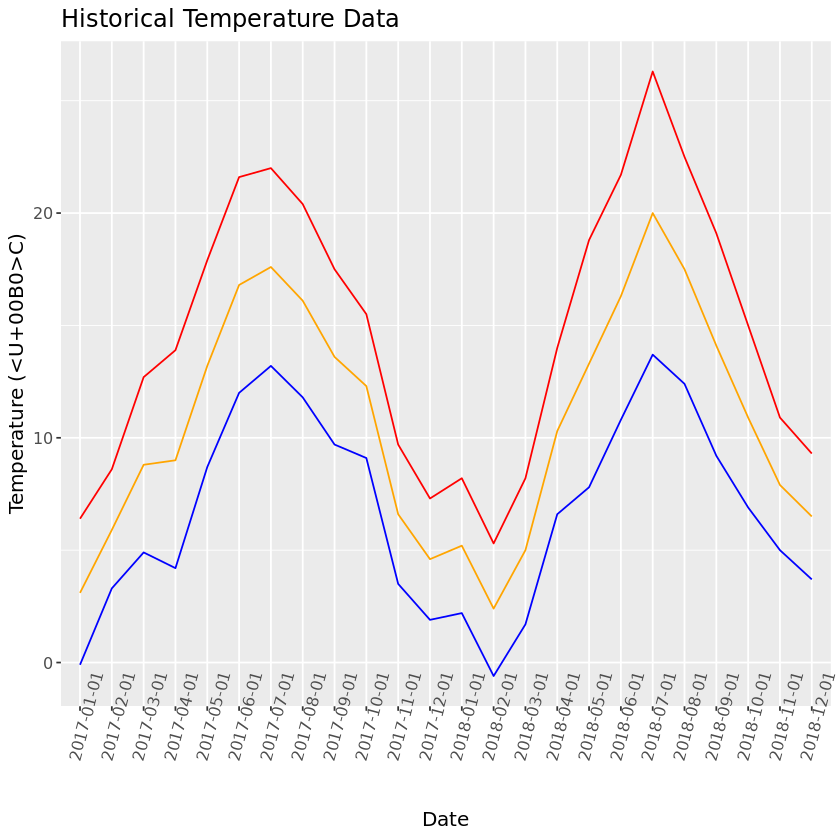

In [7]:
# plot the dataframe as timeseries chart

df <- monthlyTemperature
df$date <- as.Date(df$date)

ggplot(data=monthlyTemperature, aes(x = date)) + 
    geom_line(aes(y = temperatureMeanMonthly, group=1), color="orange") +
    geom_line(aes(y = temperatureMinMonthly, group=1),  color="blue") +
    geom_line(aes(y = temperatureMaxMonthly, group=1),  color="red") + 
    labs(
        x = "Date",
        y = "Temperature (°C)",
        title = "Historical Temperature Data"
    ) +
    theme(text = element_text(size=12), axis.text.x = element_text(angle = 75))  


## Plotting soil data

Soil information is data derived from modelling appropriately distributed samples across the UK. The data is available at a 1km grid from the CEH. See [here](https://app.agrimetrics.co.uk/catalog/data-sets/c246affc-9566-4f16-8156-81e0f8f71d79/overview) for more details.

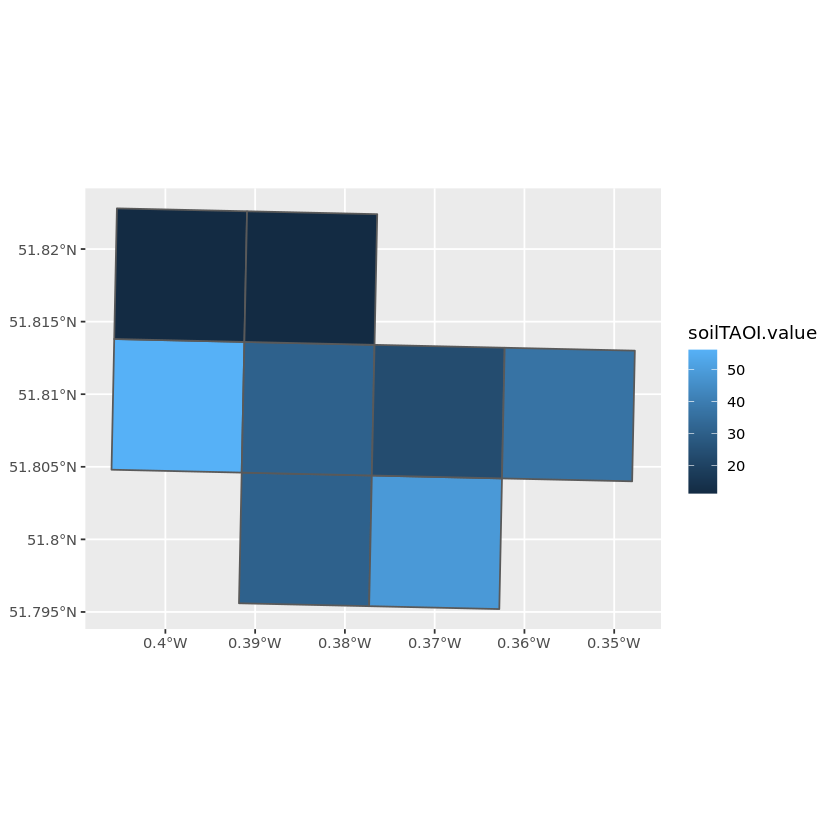

In [8]:
# get the Total Abundance of Invertebrates for the soil grids within the searched area
soilTAOI <- data$soilTotalAbundanceOfInvertebrates

# magic one liner to convert the GeoJSON location object into a list of simple features
geometry <- soilTAOI$location$shape %>% toJSON %>% geojson_sf

# bind the data to these geometries
soilTAOIData <- st_sf(cbind(soilTAOI$value, geometry))

# create a static plot, colouring the cells by Total Abundance Of Invertebrates
ggplot(soilTAOIData) + geom_sf(aes(fill = soilTAOI.value))


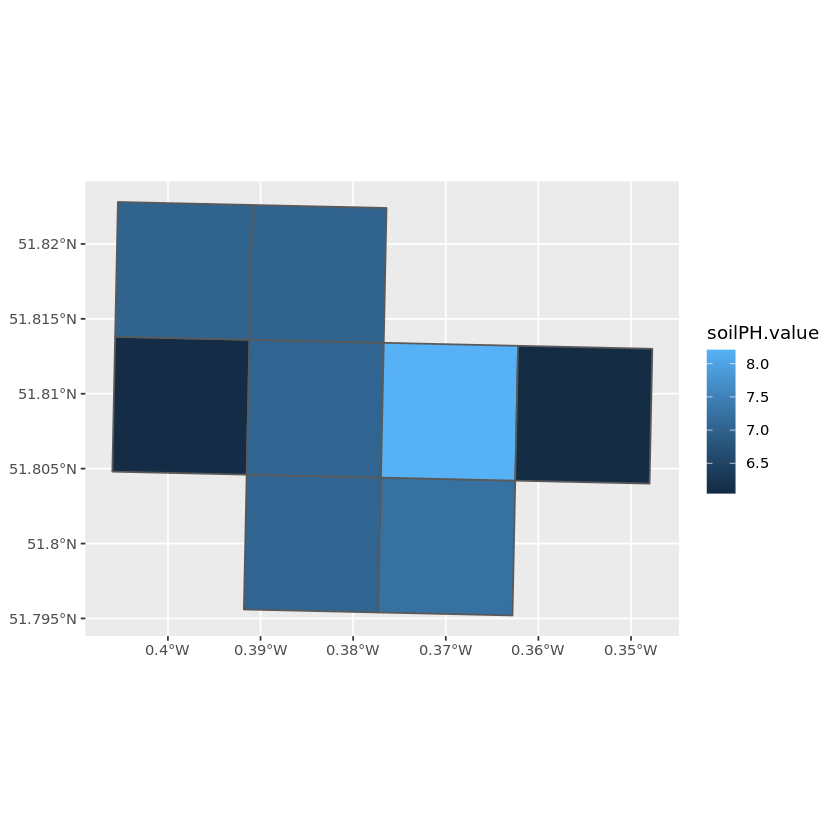

In [9]:
# get the Total Abundance of Invertebrates for the soil grids within the searched area
soilPH <- data$soilPH

# magic one liner to convert the GeoJSON location object into a dataframe of simple features
geometry <- soilPH$location$shape %>% toJSON %>% geojson_sf

# create a soilData "simple feature collection"
soilPHData <- st_sf(cbind(soilPH$value, geometry))

# create a static plot, colouring the cells by pH
ggplot(soilPHData) + geom_sf(aes(fill = soilPH.value))



## Combining the different datasets in a single plot

Without performing any analysis of the data, this cell simply presents all the following geospatial data in a single plot:
* soil pH
* total abundance of invertebrates
* monthly mean temperature for January 2018 (using previously filtered dataframe)

In [12]:
# Putting it all together

# we are only going to plot the mean temperature along with soil data

tmap_mode("plot")
tmap_leaflet(
    tm_shape(filteredDataByDate) + 
    tm_polygons("temperatureMeanMonthly", title="Temperature Mean Monthly (°C)", palette="-Greys", alpha=0.5) +
    tm_shape(soilPHData) + 
    tm_polygons("soilPH.value", title="Soil pH", palette="-Greys", alpha=0.5) +
    tm_shape(soilTAOIData) + 
    tm_polygons("soilTAOI.value", title="Total Abundance Of Invertebrates", palette="-Greys", alpha=0.5)
)


tmap mode set to plotting



![all_together.png](./all_together.png)